**Laboratorio 01**

Aplicación practica de procesamiento de base de datos de clientes de un banco X.

Codigo recuperado de Analitics and Big Data, Maldonado y Vairetti 2022 y modificado.

**Descripción de las variables**

*ID* : Numero de cliente.

*AgnosDirec*: Años que el cliente lleva viviendo en la misma direccion.

*AgnosEmpleo*: A ños de antiguedad del cliente en el mismo empleo.

*DeudaExt*: Deuda del cliente externa al banco.

*DeudaInt*: Deuda del cliente en el banco. Por ejemplo, otros créditos.

*Edad*: Edad del cliente.

*Ingreso/Ingreso2*: Ingreso del cliente recopilado de dos fuentes diferentes.

*Nacionalidad*: Nacionalidad.

*NivelEdu*: Nivel de educación.

*VarObj*: Variable objetivo. si el cliente es un mal pagador (cae en bancarrota)
en caso de recibir el credito. Si el cliente cae en bancarrota toma el valor de S
y, en el caso contrario , de N.

In [39]:
#Importamos librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

**1. Subimos un archivo**

In [40]:
path ='C:\\Users\\PC SITOS\\AnalyticsYbigData\\creditSIM.xlsx'
data_set = pd.read_excel(path)
data_set.dtypes

ID                int64
AgnosDirec      float64
AgnosEmpleo     float64
DeudaExt        float64
DeudaInt        float64
Edad            float64
Ingreso         float64
Ingreso2        float64
Nacionalidad     object
NivelEdu         object
VarObj           object
dtype: object

**2. Análisis exploratorio de datos (AED)**

**2.1 Estadisticas descriptivas**

In [41]:
data_set.describe(include='all').round(1).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,3000.0,NaN,NaN,NaN,101500.5,866.2,100001.0,100750.8,101500.5,102250.2,103000.0
AgnosDirec,2999.0,NaN,NaN,NaN,7.1,7.0,0.0,2.0,5.0,10.0,61.0
AgnosEmpleo,2998.0,NaN,NaN,NaN,7.1,6.7,0.0,2.0,5.0,10.0,47.0
DeudaExt,2999.0,NaN,NaN,NaN,4531.0,7084.8,21.6,1110.2,2278.7,5093.8,123939.2
DeudaInt,2996.0,NaN,NaN,NaN,2275.7,5409.8,8.3,416.0,958.3,2318.3,190648.9
Edad,2998.0,NaN,NaN,NaN,37.7,36.6,18.0,29.0,36.5,44.0,1970.0
Ingreso,2998.0,NaN,NaN,NaN,62567.7,49385.7,-13123.6,30282.7,49516.1,78851.5,536488.4
Ingreso2,3000.0,NaN,NaN,NaN,52152.7,42246.0,-9723.7,25109.6,40632.3,66206.2,513618.6
Nacionalidad,3000,1,N,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NivelEdu,3000,5,SupCom,979,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data_set.isnull().sum() #formula para visualizar valores perdidos

ID              0
AgnosDirec      1
AgnosEmpleo     2
DeudaExt        1
DeudaInt        4
Edad            2
Ingreso         2
Ingreso2        0
Nacionalidad    0
NivelEdu        0
VarObj          0
dtype: int64

**2.2 Gráficos**

**Grafico de frecuencia estandar para la variable edad**

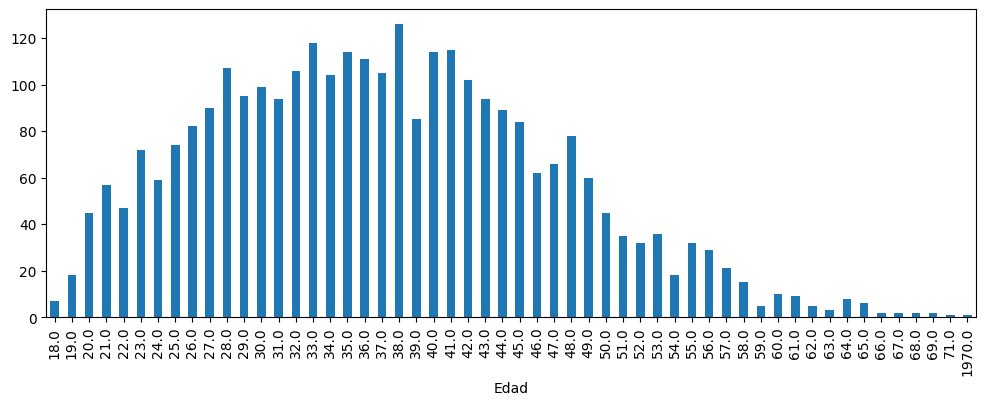

In [43]:
data_set['Edad'].value_counts().sort_index().plot.bar(figsize=(12,4))
plt.xlabel('Edad')
plt.show()

<AxesSubplot: xlabel='Ingreso'>

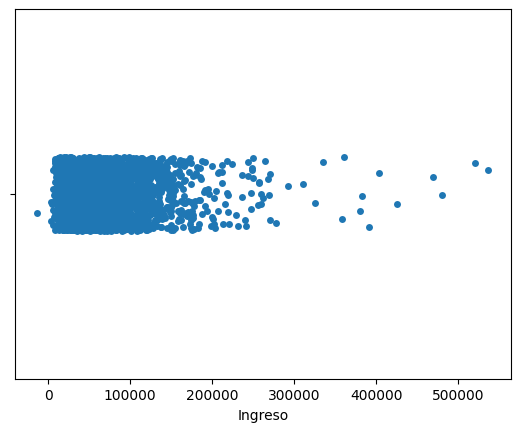

In [7]:
sn.stripplot(x='Ingreso', data=data_set)

<AxesSubplot: xlabel='NivelEdu'>

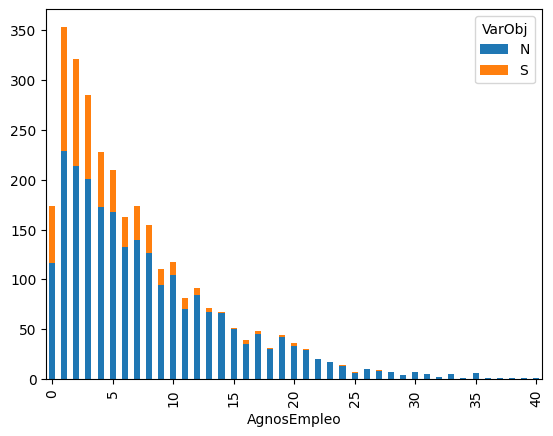

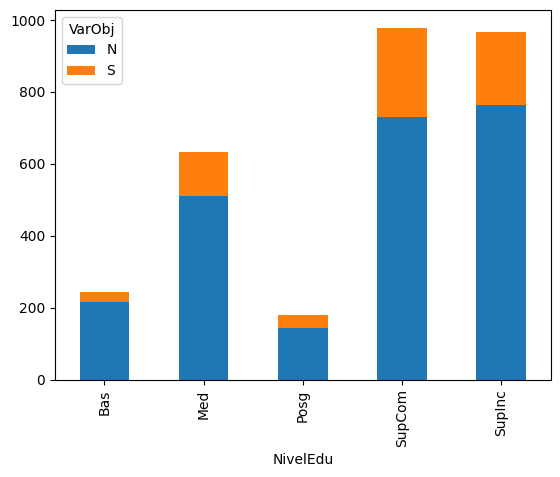

In [44]:
data_set.groupby(['AgnosEmpleo','VarObj']).size().unstack().plot.bar(stacked=True)
plt.xscale('linear')
data_set.groupby(['NivelEdu','VarObj']).size().unstack().plot.bar(stacked=True)

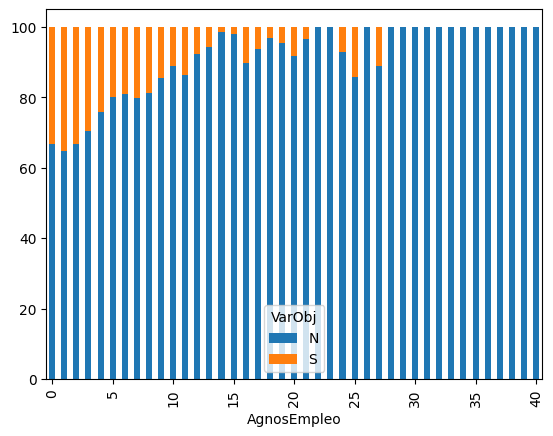

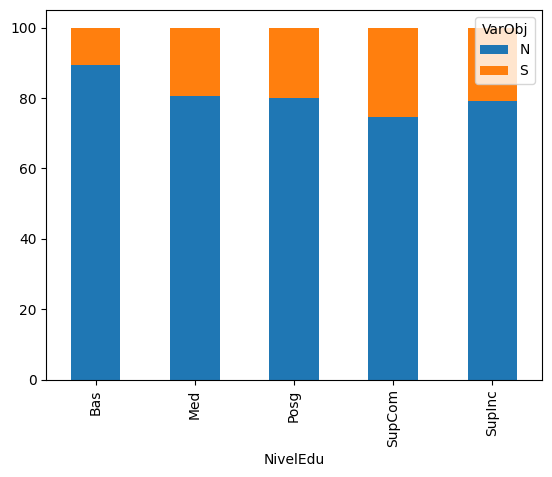

In [10]:
data_set.groupby(['AgnosEmpleo', 'VarObj']).size().groupby(level=0, group_keys=False).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
plt.xscale('linear')
plt.show()

data_set.groupby(['NivelEdu', 'VarObj']).size().groupby(level=0, group_keys=False).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
plt.show()

<AxesSubplot: xlabel='VarObj', ylabel='AgnosEmpleo'>

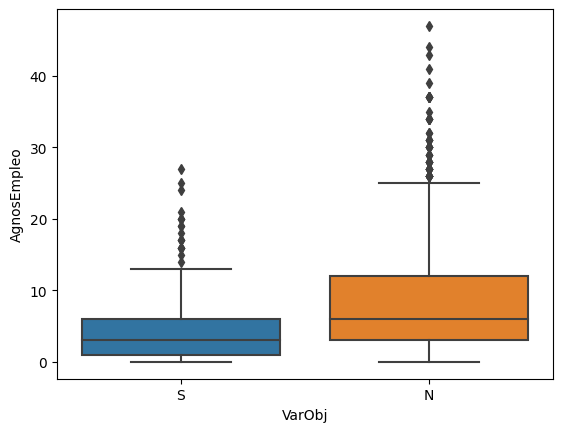

In [46]:
sn.boxplot(x='VarObj', y='AgnosEmpleo', data = data_set)

<AxesSubplot: xlabel='AgnosDirec', ylabel='AgnosEmpleo'>

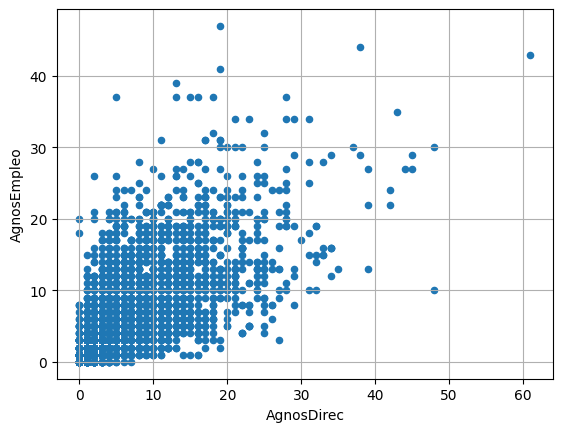

In [47]:
data_set.plot(kind='scatter', x='AgnosDirec', y = 'AgnosEmpleo', grid = True)

**3. Limpieza de datos**

**3.1 Inconsistencias**

In [48]:
data_set.loc[data_set['Ingreso']<1,['Ingreso']] =np.nan
data_set.loc[data_set['Ingreso2']<1,['Ingreso2']] =np.nan
data_set.loc[data_set['Edad']>100,['Edad']] =np.nan

**3.2 Imputar valores perdidos**

*Alternativa 1 Remplazo por mediana / moda*

Alternativa que se usa cuando los valores perdidos son menores al 5%.

In [51]:
data_set['Edad'].fillna(data_set['Edad'].median(skipna=True),inplace=True)
data_set['AgnosDirec'].fillna(data_set['AgnosDirec'].median(skipna=True),inplace=True)
data_set['AgnosEmpleo'].fillna(data_set['AgnosEmpleo'].median(skipna=True),inplace=True)
data_set['DeudaExt'].fillna(data_set['DeudaExt'].median(skipna=True),inplace=True)
data_set['DeudaInt'].fillna(data_set['DeudaInt'].median(skipna=True),inplace=True)
data_set['Ingreso'].fillna(data_set['Ingreso'].median(skipna=True),inplace=True)
data_set['Ingreso2'].fillna(data_set['Ingreso2'].median(skipna=True),inplace=True)

# moda variables categoricas
# data_set['NivelEdu'].mode()
# data_set['NivelEdu'].fillna(mode[0],inplace=True)

mode = data_set['NivelEdu'].mode()
data_set['NivelEdu'].fillna(mode[0], inplace=True)

*Alternativa 2: Eliminacion de casos (filas)*

Se usa para valores perdidos menor al 5% del total de los datos.

No se inventa información como el caso anterior pero si se pierde info.

*Alternativa 3: Imputación multiple*

Es lo mas sofisticado que sugerimos y es altamente recomendable cuando tenemos una base de datos pequeña o mediana, junto a un porcentaje de valores perddos (digamos, 5 a 30%)

In [56]:
data_set.isnull().sum()

ID              0
AgnosDirec      0
AgnosEmpleo     0
DeudaExt        0
DeudaInt        0
Edad            0
Ingreso         0
Ingreso2        0
Nacionalidad    0
NivelEdu        0
VarObj          0
dtype: int64

In [57]:
del data_set['ID']

**4. Transformación**

**4.1 Agregación**

In [58]:
# Categoricas
data_set['NivelEdu'] = data_set['NivelEdu'].replace('SupCom','Completa')
data_set['NivelEdu'] = data_set['NivelEdu'].replace('Posg','Completa')

# Numericas
# DeudaIng =(data_set['DeudaInt'] + data_set['DeudaExt'])/data_set['Ingreso']
data_set['DeudaIng'] = (data_set['DeudaExt']+data_set['DeudaInt'])/data_set['Ingreso']

**4.2 Transformación de Box - Cox (Corrección de asimetrias logaritmos)**

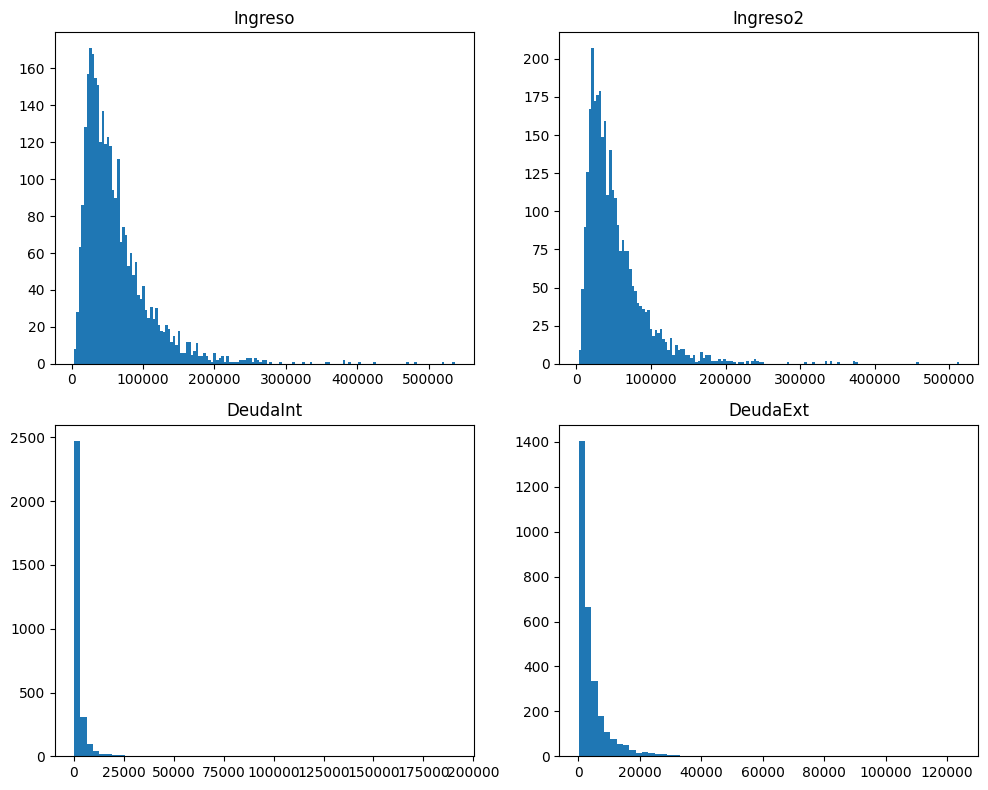

In [59]:
# import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Histograma de 'Ingreso'
axes[0, 0].hist(data_set['Ingreso'], bins=150)
axes[0, 0].set_title('Ingreso')

# Histograma de 'Ingreso2'
axes[0, 1].hist(data_set['Ingreso2'], bins=150)
axes[0, 1].set_title('Ingreso2')

# Histograma de 'DeudaInt'
axes[1, 0].hist(data_set['DeudaInt'], bins=60)
axes[1, 0].set_title('DeudaInt')

# Histograma de 'DeudaExt'
axes[1, 1].hist(data_set['DeudaExt'], bins=60)
axes[1, 1].set_title('DeudaExt')

plt.tight_layout()
plt.show()


In [60]:
data_set['Ln Ingreso'] = np.log(data_set['Ingreso']+1)
data_set['Ln Ingreso2'] = np.log(data_set['Ingreso2']+1)
data_set['Ln DeudaInt'] = np.log(data_set['DeudaInt']+1)
data_set['Ln DeudaExt'] = np.log(data_set['DeudaExt']+1)

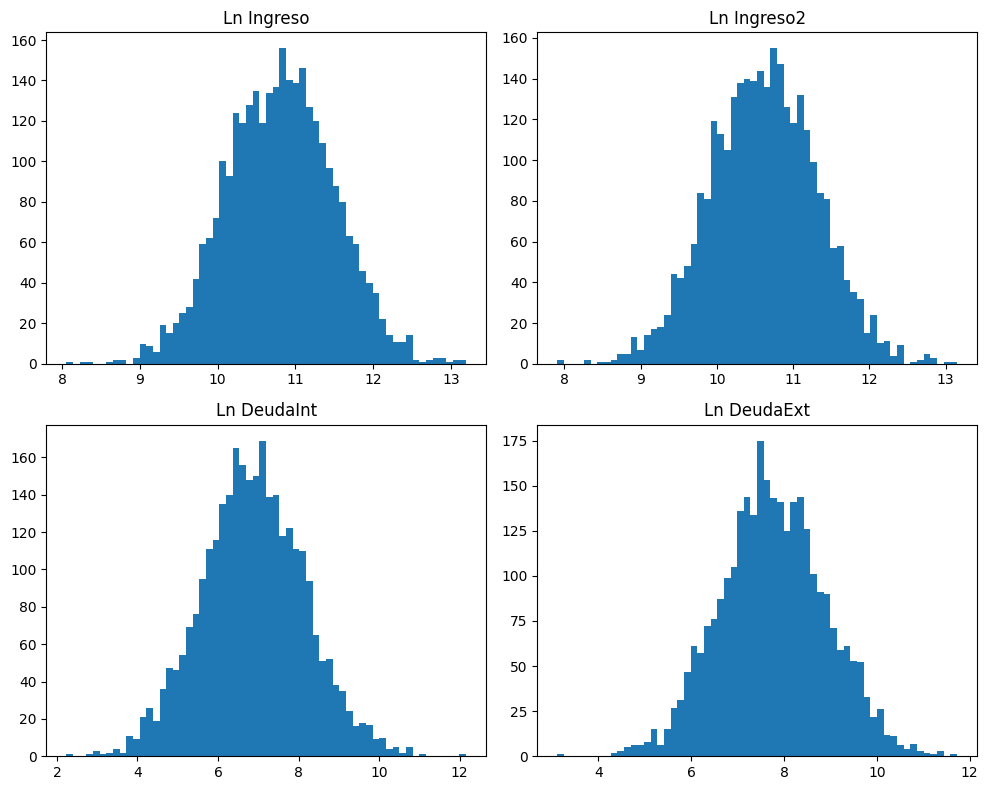

In [61]:
variables = ['Ln Ingreso', 'Ln Ingreso2', 'Ln DeudaInt', 'Ln DeudaExt']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, var in enumerate(variables):
    row = i // 2  # Calcula el número de fila del subgráfico
    col = i % 2  # Calcula el número de columna del subgráfico
    
    axes[row, col].hist(data_set[var], bins=60)
    axes[row, col].set_title(var)

plt.tight_layout()
plt.show()

In [62]:
# Eliminamos
del data_set['Ingreso']
del data_set['Ingreso2']
del data_set['DeudaInt']
del data_set['DeudaExt']

In [63]:
#Dar sentido matematico a las variables nominales
data_set = pd.get_dummies(data_set,columns = ['VarObj'], drop_first =True)
data_set = pd.get_dummies(data_set,columns = ['Nacionalidad'])

**5.Filtros (Selección de atributos)**

**5.1 Inutilidad**

In [65]:
data_set.std(numeric_only=True)

AgnosDirec        6.960621
AgnosEmpleo       6.650822
Edad              9.783355
DeudaIng          0.084710
Ln Ingreso        0.693170
Ln Ingreso2       0.701547
Ln DeudaInt       1.277791
Ln DeudaExt       1.140973
VarObj_S          0.409028
Nacionalidad_N    0.000000
dtype: float64

In [66]:
del data_set['Nacionalidad_N']

**5.2 Redundancia**

<AxesSubplot: >

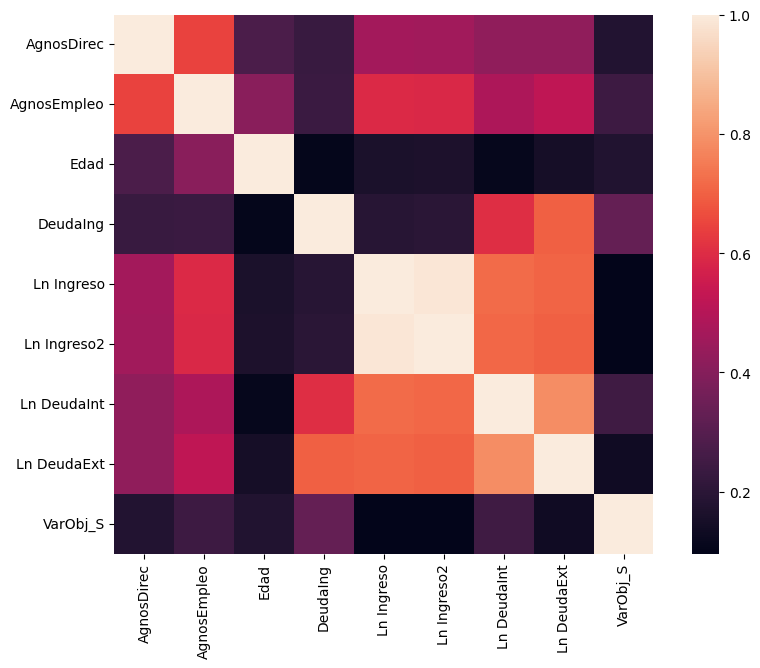

In [67]:
corrmat = data_set.corr(numeric_only=True).abs()
f,ax=plt.subplots(figsize=(10,7))
sn.heatmap(corrmat,square = True)

In [69]:
corrmat.loc['Ln Ingreso']

AgnosDirec     0.462228
AgnosEmpleo    0.593920
Edad           0.160246
DeudaIng       0.191399
Ln Ingreso     1.000000
Ln Ingreso2    0.986428
Ln DeudaInt    0.719943
Ln DeudaExt    0.703578
VarObj_S       0.098307
Name: Ln Ingreso, dtype: float64

In [70]:
del data_set['NivelEdu']

**5. Relevancia**

**5.1 Test Chi cuadrado**

In [72]:
# Discretizamos en 5 bins:
cut_points = data_set['Ln Ingreso'].quantile([0,.2,.4,.6,.8,1])
Ingreso_binned=pd.cut(data_set['Ln Ingreso'],bins=cut_points,include_lowest=True)

cut_points = data_set['Ln Ingreso2'].quantile([0,.2,.4,.6,.8,1])
Ingreso2_binned=pd.cut(data_set['Ln Ingreso2'],bins=cut_points,include_lowest=True)

In [73]:
# calculamos chi cuadrado
tbl=pd.crosstab(index=Ingreso_binned,columns=data_set['VarObj_S'])
stat,p,dof,expected=chi2_contingency(tbl)
print('valor chi cuadrado = %d'%stat)
print('p-valor = %f'%p)

tbl=pd.crosstab(index=Ingreso2_binned,columns=data_set['VarObj_S'])
stat,p,dof,expected=chi2_contingency(tbl)
print('valor chi cuadrado = %d'%stat)
print('p-valor = %f'%p)

valor chi cuadrado = 37
p-valor = 0.000000
valor chi cuadrado = 38
p-valor = 0.000000


In [74]:
del data_set['Ln Ingreso']

**5.2 selección de variables mas relevantes metodo SelectKbest**

In [75]:
X=data_set.loc[:,data_set.columns!='VarObj_S']
y=data_set.loc[:,data_set.columns=='VarObj_S']
X.shape

(3000, 7)

In [76]:
X_new = SelectKBest(k=7).fit(X, y.values.ravel())
#veamos test F y p-valor de todas las variables (no importa que diga k=5; es un numero arbitrario)
print(X_new.scores_)
print(X_new.pvalues_)

[100.59100772 185.82963936  96.67536674 367.43291817  28.06912326
 191.78625866  55.02637511]
[2.62403308e-23 4.23574061e-41 1.77966402e-22 2.39602170e-77
 1.25532267e-07 2.53352010e-42 1.53998833e-13]


**5.3 Normalización (No necesario para todos los metodos de clasificacion)**

In [77]:
VarObj=data_set['VarObj_S']
scaler=MinMaxScaler()
scaler_data=scaler.fit_transform(data_set)

data_set_scaled=pd.DataFrame(
    scaler_data,
    columns=data_set.columns)
  
print(data_set_scaled)

      AgnosDirec  AgnosEmpleo      Edad  DeudaIng  Ln Ingreso2  Ln DeudaInt  \
0       0.065574     0.042553  0.415094  0.241619     0.533283     0.676233   
1       0.459016     0.531915  0.584906  0.133651     0.656757     0.665300   
2       0.032787     0.063830  0.377358  0.053759     0.442547     0.478572   
3       0.180328     0.297872  0.471698  0.064638     0.730507     0.558412   
4       0.049180     0.021277  0.283019  0.063785     0.413664     0.484673   
...          ...          ...       ...       ...          ...          ...   
2995    0.114754     0.127660  0.188679  0.068181     0.575732     0.500450   
2996    0.049180     0.063830  0.320755  0.374006     0.460426     0.537673   
2997    0.049180     0.106383  0.207547  0.214042     0.532459     0.604681   
2998    0.213115     0.170213  0.603774  0.119091     0.599751     0.653348   
2999    0.032787     0.127660  0.113208  0.022007     0.561772     0.403166   

      Ln DeudaExt  VarObj_S  
0        0.702512    

**6. Descargar base de datos procesada**

In [78]:
ruta = "C:\\Users\\PC SITOS\\AnalyticsYbigData\\creditSIM_preprocess.csv"
data_set.to_csv(ruta, index=False)